In [1]:
try:
    import fastkaggle
except:
    !pip install -U fastkaggle

from fastai.vision.all import *
from fastkaggle import *
api = import_kaggle()

In [2]:
comp = "classification-of-plants-of-southeast-asia"
path = setup_comp(comp)
path, path.ls()

(Path('classification-of-plants-of-southeast-asia'),
 (#3) [Path('classification-of-plants-of-southeast-asia/bali-26_train'),Path('classification-of-plants-of-southeast-asia/bali-26_test'),Path('classification-of-plants-of-southeast-asia/sample_submission.csv')])

In [3]:
trn_path = path/"bali-26_train"
files_all = get_image_files(trn_path)
len(files_all), files_all[0]

(41607,
 Path('classification-of-plants-of-southeast-asia/bali-26_train/bali-26_train/frangipani/12638.jpg'))

In [23]:
from collections import defaultdict

files_by_type = defaultdict(list)
for f in files_all:
    files_by_type[f.parent.name].append(f)

sorted(((x[0], len(x[1]) / len(files_all)) for x in files_by_type.items()), key=lambda x:-x[1])

[('jackfruit', 0.06417189415242627),
 ('durian', 0.05857187492489244),
 ('dragonfruit', 0.05068858605523109),
 ('vanilla', 0.04703535462782705),
 ('guava', 0.04641045977840267),
 ('bamboo', 0.046266253274689355),
 ('waterguava', 0.04443963756098734),
 ('banana', 0.0412430600620088),
 ('starfruit', 0.040978681471867714),
 ('cacao', 0.0404258898743),
 ('papaya', 0.03953661643473454),
 ('mangosteen', 0.03903189367173793),
 ('taro', 0.03816665464945802),
 ('frangipani', 0.037661931886461414),
 ('whitepepper', 0.03386449395534405),
 ('passiflora', 0.032566635421924194),
 ('mango', 0.032278222414497564),
 ('coffeearabica', 0.03223015357992645),
 ('zodia', 0.03210998149349869),
 ('sugarpalm', 0.030187228110654458),
 ('nilam', 0.029850746268656716),
 ('cinnamon', 0.029418126757516764),
 ('sawo', 0.02937005792294566),
 ('suweg', 0.028624990987093517),
 ('snakefruit', 0.028048164972240247),
 ('lychee', 0.02682240969067705)]

In [6]:
sizes = defaultdict(int)
aspects = defaultdict(int)

for f in files_all:
    i = Image.open(f)
    sizes[i.size] += 1
    aspects[i.aspect] += 1

print(sorted(sizes.items(), key=lambda x:x[1]))
print(sorted(aspects.items(), key=lambda x:x[1]))

[((720, 1280), 403), ((1080, 1920), 14004), ((1920, 1080), 27200)]
[(0.5625, 14407), (1.7777777777777777, 27200)]


In [7]:
new_sz = (640, 360)
dest_path = Path("preproc")
def img_preproc(f):
    save_path = dest_path/f
    if save_path.exists() and Image.open(save_path).size == new_sz:
        return

    i = Image.open(f)
    if i.aspect != 1920/1080:
        i = i.transpose(Image.Transpose.TRANSPOSE)

    if i.size != new_sz:
        i = i.resize(new_sz)
    
        save_path.parent.mkdir(exist_ok=True, parents=True)
        i.save(save_path)

from fastcore.parallel import *
parallel(img_preproc, files_all, chunksize=64);

files_all = get_image_files(dest_path/trn_path)

In [10]:
files_by_type = defaultdict(list)
xs = L()
ys = L()
for f in files_all:
    xs.append(f)
    ys.append(f.parent.name)

In [30]:
_, idxs = TrainTestSplitter(stratify=ys)(xs)
xs_sub, ys_sub = xs[idxs], ys[idxs]

In [31]:
dls = DataBlock(blocks=(ImageBlock, CategoryBlock),
                get_y=parent_label,
                splitter=TrainTestSplitter(stratify=ys_sub),
                batch_tfms=aug_transforms(size=(180, 320), min_scale=0.75)
).dataloaders(xs_sub)

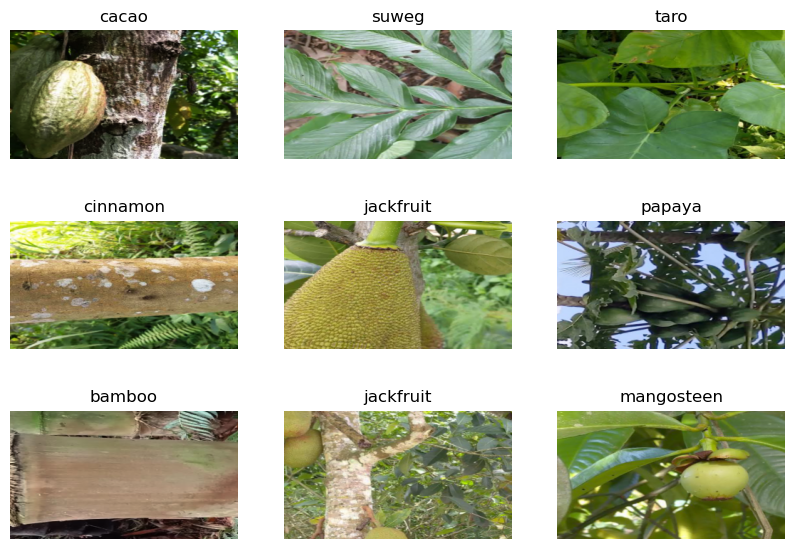

In [59]:
dls.show_batch(figsize=(10, 7))

In [72]:
import timm
timm.list_pretrained("convnext_tiny*")

['convnext_tiny.fb_in1k',
 'convnext_tiny.fb_in22k',
 'convnext_tiny.fb_in22k_ft_in1k',
 'convnext_tiny.fb_in22k_ft_in1k_384',
 'convnext_tiny.in12k',
 'convnext_tiny.in12k_ft_in1k',
 'convnext_tiny.in12k_ft_in1k_384',
 'convnext_tiny_hnf.a2h_in1k']

In [73]:
learn = vision_learner(dls, "convnext_tiny.fb_in22k", metrics=error_rate, path=".").to_fp16()

SuggestedLRs(valley=0.0006918309954926372, slide=0.0010000000474974513)

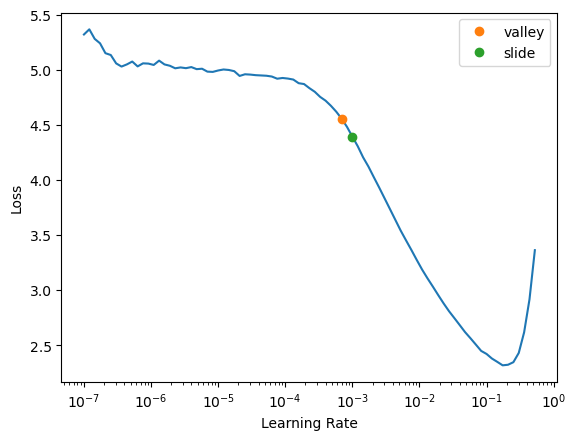

In [74]:
learn.lr_find(suggest_funcs=(valley, slide))

In [75]:
learn.fine_tune(5, 0.05)

epoch,train_loss,valid_loss,error_rate,time
0,0.688266,1.356263,0.138138,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.355230,0.585442,0.072673,00:41
1,0.402842,0.121080,0.026426,00:50
2,0.188077,0.088366,0.016216,00:54
3,0.058550,0.010954,0.001802,00:55
4,0.020161,0.005951,0.000601,00:54


In [76]:
!head {path}/"sample_submission.csv"

id, category
71.jpg,sugarpalm
11.jpg,cacao
17.jpg,frangipani
4.jpg,waterguava
75.jpg,taro
117.jpg,cacao
177.jpg,frangipani
123.jpg,waterguava
1179.jpg,taro


In [77]:
test_path = path/"bali-26_test"
parallel(img_preproc, get_image_files(test_path), chunksize=64);

In [78]:
files_test = get_image_files(dest_path/test_path)
tst_dl = dls.test_dl(files_test)

In [79]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)

In [80]:
labels = dls.vocab[idxs]

In [81]:
df = pd.DataFrame({"id": [x.name for x in files_test], "category": labels})
df.head()

,id,category
0,1567.jpg,guava
1,4184.jpg,coffeearabica
2,3558.jpg,guava
3,1809.jpg,mangosteen
4,3579.jpg,dragonfruit


In [82]:
file_subm = f"subm_{comp}.csv"
df.to_csv(file_subm, index=False)
!head {file_subm}

id,category
1567.jpg,guava
4184.jpg,coffeearabica
3558.jpg,guava
1809.jpg,mangosteen
3579.jpg,dragonfruit
253.jpg,durian
3931.jpg,starfruit
706.jpg,sugarpalm
2211.jpg,starfruit


In [83]:
api.competition_submit_cli(file_subm, "5ep more data cnxt 320x180", comp)

100%|██████████| 78.1k/78.1k [00:00<00:00, 90.5kB/s]


Successfully submitted to Classification of plants of Southeast Asia

In [92]:
api.competition_submissions_cli(comp)

fileName                                             date                 description                  status    publicScore  privateScore  
---------------------------------------------------  -------------------  ---------------------------  --------  -----------  ------------  
subm_classification-of-plants-of-southeast-asia.csv  2023-06-29 13:56:50  5ep more data cnxt 320x180   complete  0.99826      0.99826       
subm_classification-of-plants-of-southeast-asia.csv  2023-06-29 13:44:48  5ep more data rn26d 320x180  complete  0.99567      0.99480       
subm_classification-of-plants-of-southeast-asia.csv  2023-06-28 15:11:19  5ep rn26d 320x180            complete  0.94723      0.95444       
subm_classification-of-plants-of-southeast-asia.csv  2023-06-28 15:07:55  initial rn26d 320x180        complete  0.92733      0.93281       
subm_classification-of-plants-of-southeast-asia.csv  2023-06-28 15:07:33  initial rn26d 320x180        complete  0.92733      0.93281       
